##**Network Vizualisation**

##### Mount G Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/5008 Project

/content/drive/.shortcut-targets-by-id/1bBIjKsvs3fOfhtXtLG83N0fVmT-uhzTl/5008 Project



##### Import Packages:

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import folium
from tqdm import tqdm

In [ ]:
!pip install geopandas
import geopandas as gpd

!pip install cartopy
import cartopy.crs as ccrs

from scipy.spatial import ConvexHull, convex_hull_plot_2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 1.7.1
!pip install shapely==1.7.1
import shapely
from shapely.geometry import LineString

shapely.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'1.7.1'

##### Import Data:

In [ ]:
df = pd.read_csv('./Transformed_Data/src_des_info.csv', index_col = 0)
df.columns

Index(['airline', 'airline_id', 'source_airport_iata', 'source_airport_id',
       'destination_airport_iata', 'destination_airport_id', 'equipment',
       'src_ap_name', 'src_ap_type', 'src_ap_lat', 'src_ap_lon', 'src_ap_elev',
       'src_ap_continent', 'src_ap_country', 'des_ap_name', 'des_ap_type',
       'des_ap_lat', 'des_ap_lon', 'des_ap_elev', 'des_ap_continent',
       'des_ap_country'],
      dtype='object')

##### Node Plot:

Text(0.5, 1.0, 'Global Airport Plot')

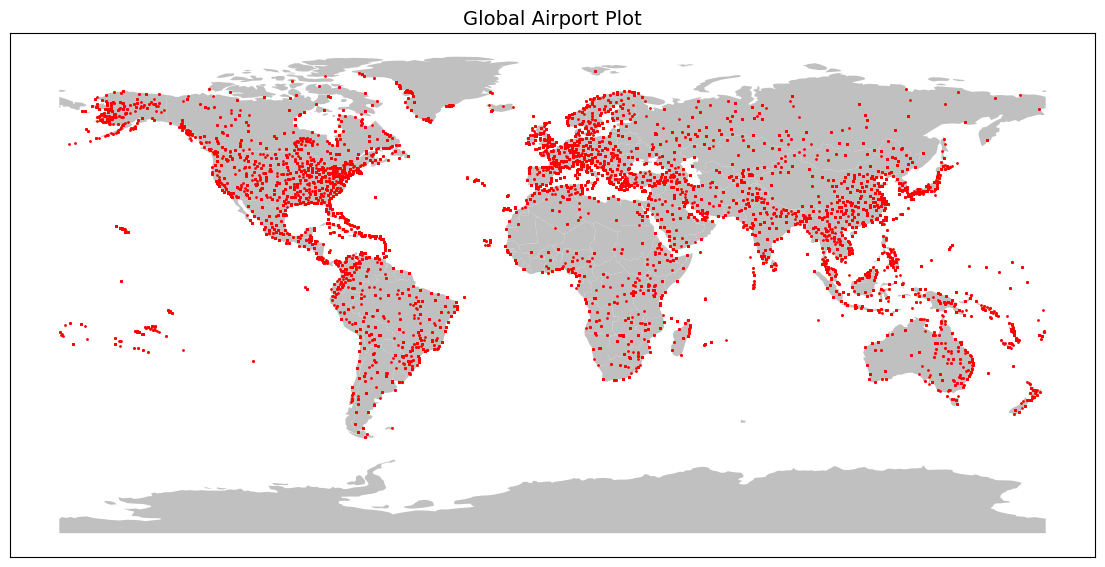

In [ ]:
# Node Plot:

worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize = (14, 7))
plt.rcParams['font.size'] = 12
plt.xticks([]) 
plt.yticks([])

worldmap.plot(color = 'silver', ax = ax)
for lat, lon in zip(df['src_ap_lat'],df['src_ap_lon']):
     ax.plot(lon, lat, 'ro', markersize=1)
 
plt.title('Global Airport Plot', fontsize=14)

##### Edge Plot:

In [ ]:
geometry = [LineString([[df.iloc[i]['src_ap_lon'], df.iloc[i]['src_ap_lat']], [df.iloc[i]['des_ap_lon'], df.iloc[i]['des_ap_lat']]]) for i in range(df.shape[0])]
routes = gpd.GeoDataFrame(df, geometry=geometry, crs = 'EPSG:4326')

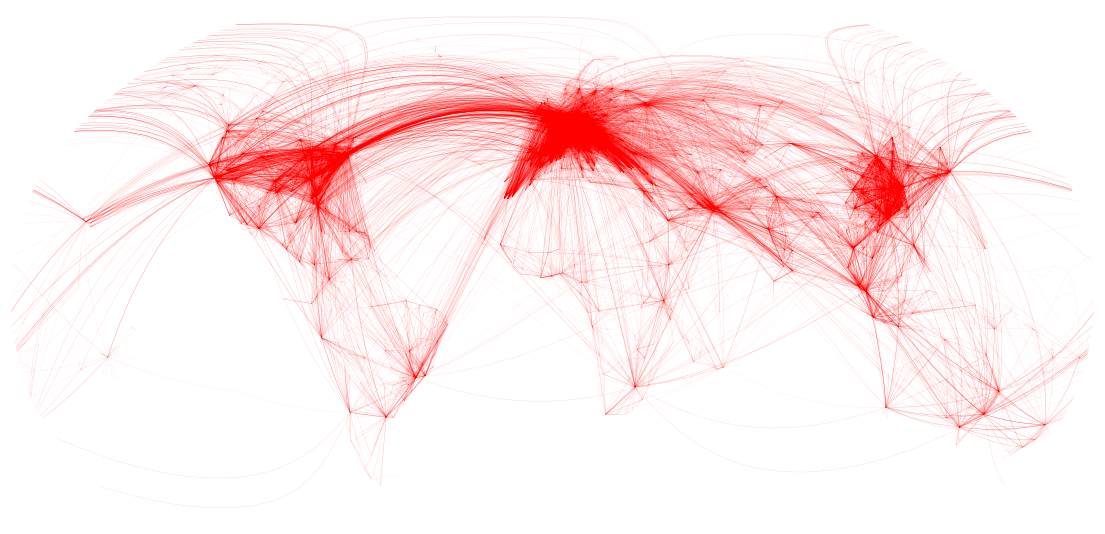

In [ ]:
#Need GPU:

fig = plt.figure(facecolor = 'white')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(14, 7)
ax.patch.set_facecolor('white')

routes.plot(ax=ax, transform=ccrs.Geodetic(), color='red', linewidth=0.1, alpha=0.1)

plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color = 'white')
ax.set_ylim(-7000000, 8800000)

plt.show()

Important Hubs:

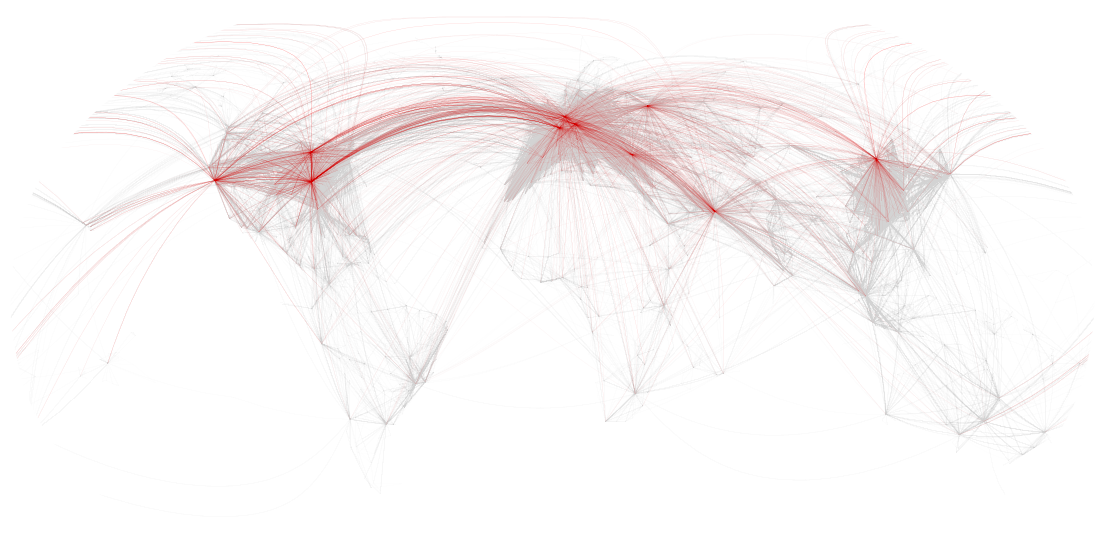

In [ ]:
#Need GPU:

hubs = ['CDG','FRA','IST','ORD','PEK','AMS','ATL','DXB','DME','LAX']
hub_routes = routes[routes['source_airport_iata'].isin(hubs)]
non_hub_routes = routes[~routes['source_airport_iata'].isin(hubs)]


fig = plt.figure(facecolor = 'white')
ax = plt.axes(projection=ccrs.Robinson())
fig.set_size_inches(14, 7)
ax.patch.set_facecolor('white')

non_hub_routes.plot(ax=ax, transform=ccrs.Geodetic(), color='lightgray', linewidth=0.1, alpha=0.1)
hub_routes.plot(ax=ax, transform=ccrs.Geodetic(), color='red', linewidth=0.1, alpha=0.1)


plt.setp(ax.spines.values(), color='white')
plt.setp([ax.get_xticklines(), ax.get_yticklines()], color = 'white')
ax.set_ylim(-7000000, 8800000)

plt.show()

##### Interactive:

In [ ]:
tmp = df.sample(50)

In [ ]:
# Create the map object
flight_map = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for the source and destination airports
for i, row in tmp.iterrows():
    src_loc = [row['src_ap_lat'], row['src_ap_lon']]
    des_loc = [row['des_ap_lat'], row['des_ap_lon']]
    src_marker = folium.Marker(src_loc, popup=row['src_ap_name'])
    des_marker = folium.Marker(des_loc, popup=row['des_ap_name'])
    flight_map.add_child(src_marker)
    flight_map.add_child(des_marker)
    folium.PolyLine([src_loc, des_loc], color='red', opacity=0.5).add_to(flight_map)

# Display the map
flight_map

## Plot for small cluster

In [ ]:
from collections import Counter
import networkx as nx

In [ ]:
df = pd.read_csv('./Transformed_Data/src_des_info.csv', index_col = 0)
G = nx.from_pandas_edgelist(df, source = 'source_airport_id', target = 'destination_airport_id', create_using=nx.DiGraph())

In [ ]:
df.columns

Index(['airline', 'airline_id', 'source_airport_iata', 'source_airport_id',
       'destination_airport_iata', 'destination_airport_id', 'equipment',
       'src_ap_name', 'src_ap_type', 'src_ap_lat', 'src_ap_lon', 'src_ap_elev',
       'src_ap_continent', 'src_ap_country', 'des_ap_name', 'des_ap_type',
       'des_ap_lat', 'des_ap_lon', 'des_ap_elev', 'des_ap_continent',
       'des_ap_country'],
      dtype='object')

In [ ]:
# extracting nodes and edges that belong to those connected components whose size < 11

# Get all weakly connected components
cc = nx.connected_components(G.to_undirected())

# Filter out components with size <= 10
small_cc = [c for c in cc if len(c) <= 10]

# Flatten the list of small connected components
small_cc = set.union(*small_cc)

# Create a new dataframe with only the nodes in small connected components
df_small_cc = df[df['source_airport_id'].isin(small_cc) | df['destination_airport_id'].isin(small_cc)]

# Extract the required columns from the original dataframe and create the new dataframe
new_df = df_small_cc[['src_ap_name', 'src_ap_type', 'src_ap_lat', 'src_ap_lon', 'des_ap_name', 'des_ap_type', 'des_ap_lat', 'des_ap_lon']].copy()

df = new_df.copy()

In [ ]:
# Create the map object
flight_map = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for the source and destination airports
for i, row in df.iterrows():
    src_loc = [row['src_ap_lat'], row['src_ap_lon']]
    des_loc = [row['des_ap_lat'], row['des_ap_lon']]
    src_marker = folium.Marker(src_loc, popup=row['src_ap_name'])
    des_marker = folium.Marker(des_loc, popup=row['des_ap_name'])
    flight_map.add_child(src_marker)
    flight_map.add_child(des_marker)
    folium.PolyLine([src_loc, des_loc], color='red', opacity=0.5).add_to(flight_map)

# Display the map
flight_map